# KernelSHAP: combining preprocessor and predictor

<div class="alert alert-info">
Note

To enable SHAP support, you may need to run
    
```bash
pip install alibi[shap]
```

</div>

## Introduction

In [this](kernel_shap_adult_lr.ipynb) example, we showed that the categorical variables can be handled by fitting the explainer on preprocessed data and passing preprocessed data to the `explain` call. To handle the categorical variables, we either group them explicitly or sum the estimated shap values for each encoded shap dimension. An alternative way is to define our black-box model to include the preprocessor, as shown in [this](anchor_tabular_adult.ipynb) example. We now show that these methods give the same results.

In [ ]:
import shap
shap.initjs()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from alibi.explainers import KernelShap
from alibi.datasets import fetch_adult
from scipy.special import logit
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Data preparation

### Load and split

The `fetch_adult` function returns a `Bunch` object containing the features, the targets, the feature names and a mapping of categorical variables to numbers.

In [2]:
adult = fetch_adult()
adult.keys()

dict_keys(['data', 'target', 'feature_names', 'target_names', 'category_map'])

In [3]:
data = adult.data
target = adult.target
target_names = adult.target_names
feature_names = adult.feature_names
category_map = adult.category_map

Note that for your own datasets you can use our utility function `gen_category_map` to create the category map.

In [4]:
from alibi.utils import gen_category_map

In [5]:
np.random.seed(0)
data_perm = np.random.permutation(np.c_[data, target])
data = data_perm[:,:-1]
target = data_perm[:,-1]

In [6]:
idx = 30000
X_train,y_train = data[:idx,:], target[:idx]
X_test, y_test = data[idx+1:,:], target[idx+1:]

### Create feature transformation pipeline

Create feature pre-processor. Needs to have 'fit' and 'transform' methods. Different types of pre-processing can be applied to all or part of the features. In the example below we will standardize ordinal features and apply one-hot-encoding to categorical features.

Ordinal features:

In [7]:
ordinal_features = [x for x in range(len(feature_names)) if x not in list(category_map.keys())]
ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

Categorical features:

In [8]:
categorical_features = list(category_map.keys())
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

Note that in order to be able to interpret the coefficients corresponding to the categorical features, the option `drop='first'` has been passed to the `OneHotEncoder`. This means that for a categorical variable with `n` levels, the length of the code will be `n-1`. This is necessary in order to avoid introducing feature multicolinearity, which would skew the interpretation of the results. For more information about the issue about multicolinearity in the context of linear modelling see [[1]](#References).
<a id='src_1'></a>

Combine and fit:

In [9]:
preprocessor = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features),
                                               ('cat', categorical_transformer, categorical_features)])
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 [0, 8, 9, 10]),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'))]),
                                 [1, 2, 3, 4, 5, 6, 7, 11])])

## Fit a binary logistic regression classifier to the preprocessed Adult dataset

### Preprocess the data

In [10]:
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

### Training 

In [11]:
classifier = LogisticRegression(multi_class='multinomial',
                                random_state=0,
                                max_iter=500,
                                verbose=0,
                               )
classifier.fit(X_train_proc, y_train)

LogisticRegression(max_iter=500, multi_class='multinomial', random_state=0)

### Model assessment

In [12]:
y_pred = classifier.predict(X_test_proc)

In [13]:
cm = confusion_matrix(y_test, y_pred)

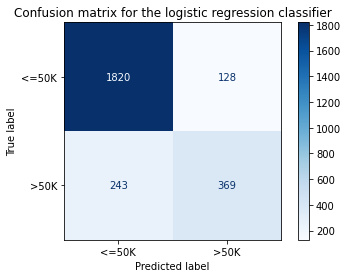

In [14]:
title = 'Confusion matrix for the logistic regression classifier'
disp = ConfusionMatrixDisplay.from_estimator(classifier, 
                                             X_test_proc, 
                                             y_test,
                                             display_labels=target_names,
                                             cmap=plt.cm.Blues,
                                             normalize=None,
                                            )
disp.ax_.set_title(title);

In [15]:
print('Test accuracy: ', accuracy_score(y_test, classifier.predict(X_test_proc)))

Test accuracy:  0.855078125


## Explaining the model with an explainer fitted on the preprocessed data

To speed up computation, we will use a background dataset with only `100` samples.

In [16]:
start_example_idx = 0
stop_example_idx = 100
background_data = slice(start_example_idx, stop_example_idx)

First, we group the categorical variables.

In [17]:
def make_groups(num_feats_names, cat_feats_names, feat_enc_dim):
    """
    Given a list with numerical feat. names, categorical feat. names
    and a list specifying the lengths of the encoding for each cat.
    varible, the function outputs a list of group names, and a list
    of the same len where each entry represents the column indices that
    the corresponding categorical feature 
    """
    
    group_names = num_feats_names + cat_feats_names
    groups = []
    cat_var_idx = 0
    
    for name in group_names: 
        if name in num_feats_names:
            groups.append(list(range(len(groups), len(groups) + 1)))
        else:
            start_idx = groups[-1][-1] + 1 if groups else 0
            groups.append(list(range(start_idx, start_idx + feat_enc_dim[cat_var_idx] )))
            cat_var_idx += 1
    
    return group_names, groups
            
def sparse2ndarray(mat, examples=None):
    """
    Converts a scipy.sparse.csr.csr_matrix to a numpy.ndarray.
    If specified, examples is slice object specifying which selects a
    number of rows from mat and converts only the respective slice.
    """
    
    if examples:
        return mat[examples, :].toarray()
    
    return mat.toarray()

In [18]:
# obtain the indices of the categorical and the numerical features from the pipeline.
numerical_feats_idx  = preprocessor.transformers_[0][2]
categorical_feats_idx  = preprocessor.transformers_[1][2]
num_feats_names = [feature_names[i] for i in numerical_feats_idx]
cat_feats_names = [feature_names[i] for i in categorical_feats_idx]
perm_feat_names = num_feats_names + cat_feats_names 
ohe = preprocessor.transformers_[1][1].named_steps['onehot']
feat_enc_dim = [len(cat_enc) - 1 for cat_enc in ohe.categories_]

In [19]:
# create the groups
X_train_proc_d = sparse2ndarray(X_train_proc, examples=background_data)
group_names, groups = make_groups(num_feats_names, cat_feats_names, feat_enc_dim)

Having created the groups, we are now ready to instantiate the explainer and explain our set.

In [20]:
pred_fcn = classifier.predict_proba
grp_lr_explainer = KernelShap(pred_fcn, link='logit', feature_names=perm_feat_names, seed=0)
grp_lr_explainer.fit(X_train_proc_d, group_names=group_names, groups=groups)

KernelShap(meta={'name': 'KernelShap', 'type': 'blackbox', 'explanations': ['local', 'global'], 'params': {'groups': [[0], [1], [2], [3], [4, 5, 6, 7, 8, 9, 10, 11], [12, 13, 14, 15, 16, 17], [18, 19, 20], [21, 22, 23, 24, 25, 26, 27, 28], [29, 30, 31, 32, 33], [34, 35, 36, 37], [38], [39, 40, 41, 42, 43, 44, 45, 46, 47, 48]], 'group_names': ['Age', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Workclass', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'], 'weights': None, 'summarise_background': False}})

We select only a small fraction of the testing set to explain for the purposes of this example.

In [21]:
def split_set(X, y, fraction, random_state=0):
    """
    Given a set X, associated labels y, split\\s a fraction y from X.
    """
    _, X_split, _, y_split = train_test_split(X, 
                                              y, 
                                              test_size=fraction, 
                                              random_state=random_state,
                                             )
    print("Number of records: {}".format(X_split.shape[0]))
    print("Number of class {}: {}".format(0, len(y_split) - y_split.sum()))
    print("Number of class {}: {}".format(1, y_split.sum()))
    
    return X_split, y_split

In [22]:
fraction_explained = 0.01 
X_explain, y_explain = split_set(X_test, 
                                 y_test, 
                                 fraction_explained, 
                                 )
X_explain_proc = preprocessor.transform(X_explain)
X_explain_proc_d = sparse2ndarray(X_explain_proc)

Number of records: 26
Number of class 0: 20
Number of class 1: 6


In [ ]:
grouped_explanation = grp_lr_explainer.explain(X_explain_proc_d)

### Explaining with an explainer fitted on the raw data

To explain with an explainer fitted on the raw data, we make the preprocessor part of the predictor, as shown below.

In [24]:
pred_fcn = lambda x: classifier.predict_proba(preprocessor.transform(x))
lr_explainer = KernelShap(pred_fcn, link='logit', feature_names=feature_names, seed=0)

We use the same background dataset to fit the explainer.

In [25]:
lr_explainer.fit(X_train[background_data])

KernelShap(meta={'name': 'KernelShap', 'type': 'blackbox', 'explanations': ['local', 'global'], 'params': {'groups': None, 'group_names': None, 'weights': None, 'summarise_background': False}})

We explain the same dataset as before.

In [ ]:
explanation = lr_explainer.explain(X_explain)

### Results comparison

To show that fitting the explainer on the raw data and combining the preprocessor with the classifier gives the same results as grouping the variables and fitting the explainer on the preprocessed data, we check to see that the same features are considered as most important when combining the two approaches.

In [27]:
def get_ranked_values(explanation):
    """
    Retrives a tuple of (feature_effects, feature_names) for
    each class explained. A feature's effect is its average
    shap value magnitude across an array of instances.
    """
    
    ranked_shap_vals = []
    for cls_idx in range(len(explanation.shap_values)):
        this_ranking = (
            explanation.raw['importances'][str(cls_idx)]['ranked_effect'],
            explanation.raw['importances'][str(cls_idx)]['names']
                       )
        ranked_shap_vals.append(this_ranking)
    
    return ranked_shap_vals

def compare_ranking(ranking_1, ranking_2, methods=None):
    for i, (combined, grouped) in enumerate(zip(ranking_1, ranking_2)):
        print(f"Class: {i}")
        c_names, g_names = combined[1], grouped[1]
        c_mag, g_mag = combined[0], grouped[0]
        different = []
        for i, (c_n, g_n) in enumerate(zip(c_names, g_names)):
            if c_n != g_n:
                different.append((i, c_n, g_n))
        if different:
            method_1 = methods[0] if methods else "Method_1"
            method_2 = methods[1] if methods else "Method_2"
            i, c_ns, g_ns = list(zip(*different))
            data = {"Rank": i, method_1: c_ns, method_2: g_ns}
            df = pd.DataFrame(data=data)
            print("Found the following rank differences:")
            print(df)
        else:
            print("The methods provided the same ranking for the feature effects.")
            print(f"The ranking is: {c_names}")
        print("")
        
def reorder_feats(vals_and_names, src_vals_and_names):
    """Given a two tuples, each containing a list of ranked feature
    shap values and the corresponding feature names, the function 
    reorders the values in vals according to the order specified in
    the list of names contained in src_vals_and_names.
    """
    
    _, src_names = src_vals_and_names
    vals, names = vals_and_names
    reordered = np.zeros_like(vals)
    
    for i, name in enumerate(src_names):
        alt_idx = names.index(name)
        reordered[i] = vals[alt_idx]
    
    return reordered, src_names

def compare_avg_mag_shap(class_idx, comparisons, baseline, **kwargs):
    """
    Given a list of tuples, baseline, containing the feature values and a list with feature names 
    for each class and, comparisons, a list of lists with tuples with the same structure , the 
    function reorders the values of the features in comparisons entries according to the order 
    of the feature names provided in the baseline entries and displays the feature values for comparison.
    """
    
    methods = kwargs.get("methods", [f"method_{i}" for i in range(len(comparisons) + 1)])
    
    n_features = len(baseline[class_idx][0])
    
    # bar settings
    bar_width = kwargs.get("bar_width", 0.05)
    bar_space = kwargs.get("bar_space", 2)
    
    # x axis 
    x_low = kwargs.get("x_low", 0.0)
    x_high = kwargs.get("x_high", 1.0)
    x_step = kwargs.get("x_step", 0.05)
    x_ticks = np.round(np.arange(x_low, x_high + x_step, x_step), 3)

    # y axis (these are the y coordinate of start and end of each group 
    # of bars)
    start_y_pos = np.array(np.arange(0, n_features))*bar_space
    end_y_pos = start_y_pos + bar_width*len(methods)
    y_ticks = 0.5*(start_y_pos + end_y_pos)
    
    # figure 
    fig_x = kwargs.get("fig_x", 10)
    fig_y = kwargs.get("fig_y", 7)
    
    # fontsizes 
    title_font = kwargs.get("title_fontsize", 20)
    legend_font = kwargs.get("legend_fontsize", 20)
    tick_labels_font = kwargs.get("tick_labels_fontsize", 20)
    axes_label_fontsize = kwargs.get("axes_label_fontsize", 10)
    
    # labels 
    title = kwargs.get("title", None)
    ylabel = kwargs.get("ylabel", None)
    xlabel = kwargs.get("xlabel", None)
    
    # process input data 
    methods = list(reversed(methods))
    base_vals = baseline[class_idx][0] 
    ordering = baseline[class_idx][1]
    comp_vals = []
    
    # reorder the features so that they match the order of the baseline (ordering)
    for comparison in comparisons:
        vals, ord_ = reorder_feats(comparison[class_idx], baseline[class_idx])
        comp_vals.append(vals)
        assert ord_ is ordering 
        
    all_vals = [base_vals] + comp_vals
    data = dict(zip(methods, all_vals))
    df = pd.DataFrame(data=data, index=ordering)
    
    # plotting logic
    fig, ax = plt.subplots(figsize=(fig_x, fig_y))

    for i, col in enumerate(df.columns):
        values = list(df[col])
        y_pos = [y + bar_width*i for y  in start_y_pos] 
        ax.barh(y_pos, list(values), bar_width, label=col)
    
    # add ticks, legend and labels
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(x) for x in x_ticks], rotation=45, fontsize=tick_labels_font)
    ax.set_xlabel(xlabel, fontsize=axes_label_fontsize)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(ordering, fontsize=tick_labels_font)
    ax.set_ylabel(ylabel, fontsize=axes_label_fontsize)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.legend(fontsize=legend_font)   

    plt.grid(True)
    plt.title(title, fontsize=title_font)

    return ax, fig, df

In [28]:
ranked_grouped_shap_vals = get_ranked_values(grouped_explanation)
ranked_shal_vals_raw = get_ranked_values(explanation)
compare_ranking(ranked_grouped_shap_vals, ranked_shal_vals_raw)

Class: 0
The methods provided the same ranking for the feature effects.
The ranking is: ['Marital Status', 'Capital Gain', 'Education', 'Occupation', 'Sex', 'Relationship', 'Age', 'Hours per week', 'Workclass', 'Capital Loss', 'Country', 'Race']

Class: 1
The methods provided the same ranking for the feature effects.
The ranking is: ['Marital Status', 'Capital Gain', 'Education', 'Occupation', 'Sex', 'Relationship', 'Age', 'Hours per week', 'Workclass', 'Capital Loss', 'Country', 'Race']



Above we can see that both methods returned the same feature importances. 

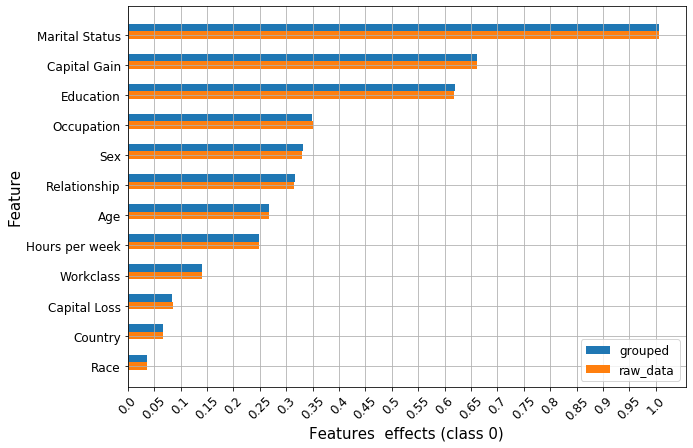

In [29]:
class_idx = 0 

ax, fig, _ = compare_avg_mag_shap(class_idx, 
                               [ranked_shal_vals_raw], 
                               ranked_grouped_shap_vals, 
                               methods=('raw_data', 'grouped'),
                               bar_width=0.5,
                               tick_labels_fontsize=12,
                               legend_fontsize=12,
                               title_fontsize=15,
                               xlabel="Features  effects (class {})".format(0),
                               ylabel="Feature",
                               axes_label_fontsize=15,
                               )

We can see that the shap values are very similar. The differences appear because the regression dataset generated in order to compute the shap values differes slightly between the two runs due to the difference in the order of the features in the background dataset.


### References

<a id='References'></a>

[[1]](#src_1) *Mahto, K.K., 2019. "One-Hot-Encoding, Multicollinearity and the Dummy Variable Trap". Retrieved 02 Feb 2020*  [(link)](https://towardsdatascience.com/one-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a)